<a href="https://colab.research.google.com/github/aleksmirosh/Big-Data-School/blob/main/Cars_model_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define car's models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import cv2 
import os 
from random import shuffle 
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [ ]:
#check for cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


### a-b.) Load train and test datasets 

In [ ]:
tfms = transforms.Compose([transforms.Resize((224, 224)), #best size for ResNet
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #normalize influences a lot on model speed and accuracy

dataset_dir = "/content/drive/MyDrive/Colab Notebooks/cars/"

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 64, shuffle=False, num_workers = 2)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

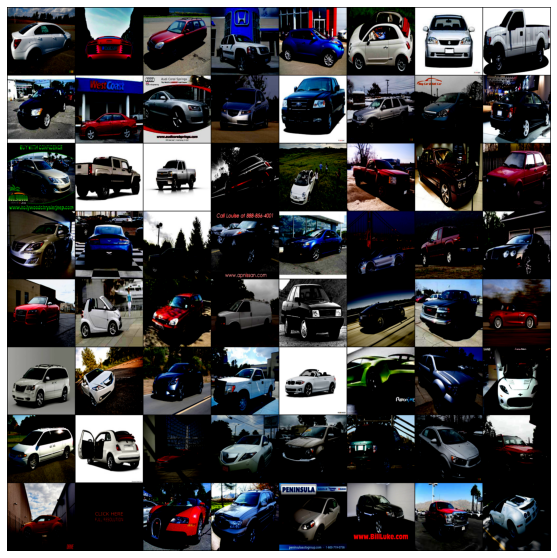

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(trainloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

### c-d.) Define custom Convolutional neural network with 1, 2, 3, 4 Conv2D and pooling layers. 

Train and evaluate the models

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs):
    losses = []
    accuracies = []
    test_accuracies = []
    test_loss = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/64*running_correct/len(trainloader)
        print("Epoch {}, duration: {} s, loss: {}, acc: {}".format(epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_ep_loss, test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        test_loss.append(test_ep_loss)

        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return losses, accuracies, test_loss, test_accuracies

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    tloss = []
    run_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            # get the inputs and assign them to cuda
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # calculate the loss/acc later
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            tloss = criterion(outputs, labels)
            run_loss += tloss.item()

    test_epoch_loss = run_loss/len(testloader)
    test_acc = 100.0 * correct / total
    print('test. loss: {}, acc: {}'.format(test_epoch_loss, test_acc))
    return test_epoch_loss, test_acc

1 Conv Layer

In [ ]:
#reference is AlexNet
class Net(nn.Module):
    def __init__(self, num_classes: int = 196) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.av_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc1 = nn.Linear(64 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.av_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
    
        return x

net=Net()
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
training_losses, training_accs, test_losses, test_accs = train_model(net, criterion, optimizer, lrscheduler, n_epochs=20)

Epoch 1, duration: 83.51224446296692 s, loss: 5.278256766498089, acc: 0.67138671875
test. loss: 5.264121195626637, acc: 0.907847282676284
Epoch 2, duration: 81.46788430213928 s, loss: 5.241613291203976, acc: 1.13525390625
test. loss: 5.214226120994205, acc: 1.305807735356299
Epoch 3, duration: 80.89505791664124 s, loss: 5.120335340499878, acc: 1.94091796875
test. loss: 5.097965401316446, acc: 1.9027484143763214
Epoch 4, duration: 81.06131100654602 s, loss: 4.985298179090023, acc: 2.52685546875
test. loss: 5.061005673711262, acc: 2.4126352443725905
Epoch 5, duration: 80.14356017112732 s, loss: 4.860166143625975, acc: 3.72314453125
test. loss: 5.027458505024986, acc: 2.823031961198856
Epoch 6, duration: 80.58563280105591 s, loss: 4.718832243233919, acc: 5.0048828125
test. loss: 5.037083905840677, acc: 3.370227583633876
Epoch 7, duration: 81.83401679992676 s, loss: 4.57551696151495, acc: 6.3232421875
test. loss: 5.049658162253244, acc: 3.2458649421713717
Epoch 8, duration: 82.538734197616

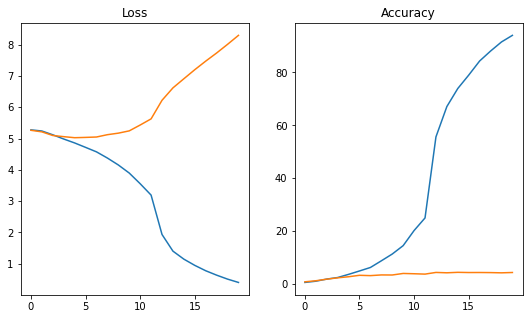

In [ ]:
f, ax = plt.subplots(1,2, figsize = (9, 5))
ax[0].set_title("Loss")
ax[0].plot(training_losses)
ax[0].plot(test_losses)
ax[1].set_title("Accuracy")
ax[1].plot(training_accs)
ax[1].plot(test_accs)

2 Conv Layer

In [ ]:
#reference is AlexNet
class Net(nn.Module):
    def __init__(self, num_classes: int = 196) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.av_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc1 = nn.Linear(192 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.av_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
    
        return x

net=Net()
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
training_losses, training_accs, test_losses, test_accs = train_model(net, criterion, optimizer, lrscheduler, n_epochs=20)

Epoch 1, duration: 87.44858860969543 s, loss: 5.279184598475695, acc: 0.64697265625
test. loss: 5.271657879390414, acc: 0.8456659619450317
Epoch 2, duration: 87.04195713996887 s, loss: 5.254388090223074, acc: 0.927734375
test. loss: 5.18621405722603, acc: 1.5918418107200596
Epoch 3, duration: 85.039546251297 s, loss: 5.14374715462327, acc: 1.5625
test. loss: 5.098469389809503, acc: 1.840567093645069
Epoch 4, duration: 82.76894497871399 s, loss: 5.048083309084177, acc: 2.38037109375
test. loss: 5.055255142469255, acc: 2.0146747916925754
Epoch 5, duration: 84.33230805397034 s, loss: 4.952109105885029, acc: 2.67333984375
test. loss: 5.022761072431292, acc: 2.93495833851511
Epoch 6, duration: 89.97605681419373 s, loss: 4.832268752157688, acc: 3.60107421875
test. loss: 4.956948223568144, acc: 3.3453550553413756
Epoch 7, duration: 87.74435591697693 s, loss: 4.705181505531073, acc: 5.01708984375
test. loss: 4.926121933119638, acc: 3.681134187290138
Epoch 8, duration: 88.25903391838074 s, loss

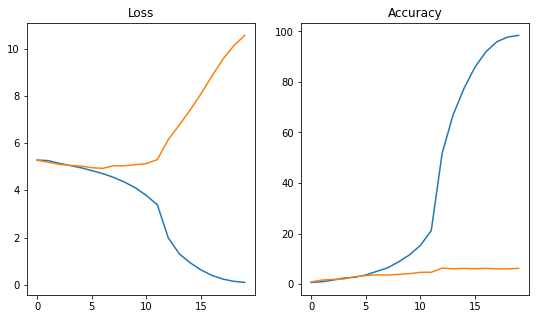

In [ ]:
f, ax = plt.subplots(1,2, figsize = (9, 5))
ax[0].set_title("Loss")
ax[0].plot(training_losses)
ax[0].plot(test_losses)
ax[1].set_title("Accuracy")
ax[1].plot(training_accs)
ax[1].plot(test_accs)

3 Conv Layers, 4 poolings

In [ ]:
#reference is AlexNet
class Net(nn.Module):
    def __init__(self, num_classes: int = 196) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.av_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc1 = nn.Linear(384 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.av_pool(self.pool(F.relu(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
    
        return x

net=Net()
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
training_losses, training_accs, test_losses, test_accs = train_model(net, criterion, optimizer, lrscheduler, n_epochs=20)

Epoch 1, duration: 66.39136672019958 s, loss: 5.1180652668601585, acc: 0.7730263157894737
test. loss: 5.302233504152846, acc: 0.778421433743664
Epoch 2, duration: 67.69922256469727 s, loss: 5.086658241874293, acc: 1.167763157894737
test. loss: 5.2962293789304535, acc: 0.6154960173787111
Epoch 3, duration: 66.1040449142456 s, loss: 5.000551078194066, acc: 1.7763157894736843
test. loss: 5.4495201823355135, acc: 0.4887762490948588
Epoch 4, duration: 66.70421528816223 s, loss: 4.897844861683093, acc: 2.236842105263158
test. loss: 5.393535244053807, acc: 0.724112961622013
Epoch 5, duration: 66.38754844665527 s, loss: 4.82797088121113, acc: 2.7467105263157894
test. loss: 5.529611143572577, acc: 0.5973931933381608
Epoch 6, duration: 67.62005352973938 s, loss: 4.74696054960552, acc: 3.601973684210526
test. loss: 5.587818721245075, acc: 0.56118754525706
Epoch 7, duration: 67.49871706962585 s, loss: 4.657265116039075, acc: 4.555921052631579
test. loss: 5.578886415766574, acc: 0.7060101375814627


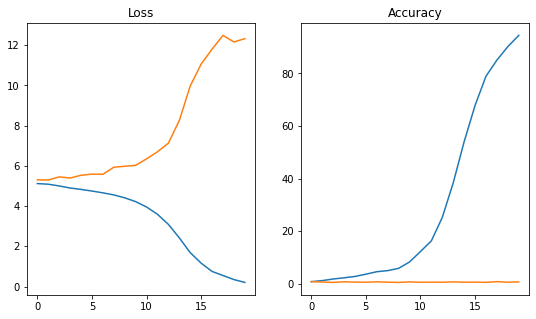

In [ ]:
f, ax = plt.subplots(1,2, figsize = (9, 5))
ax[0].set_title("Loss")
ax[0].plot(training_losses)
ax[0].plot(test_losses)
ax[1].set_title("Accuracy")
ax[1].plot(training_accs)
ax[1].plot(test_accs)

4 Layers, 3 pooling

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 196) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
    
        return x

net=Net()
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
training_losses, training_accs, test_losses, test_accs = train_model(net, criterion, optimizer, lrscheduler, n_epochs=20)

Epoch 1, duration: 85.4659812450409 s, loss: 5.276995778083801, acc: 0.830078125
test. loss: 5.2747811438545344, acc: 0.8456659619450317
Epoch 2, duration: 88.4382951259613 s, loss: 5.274937234818935, acc: 0.830078125
test. loss: 5.270502502956088, acc: 0.8456659619450317
Epoch 3, duration: 86.88813471794128 s, loss: 5.264204788953066, acc: 0.87890625
test. loss: 5.235710083492219, acc: 1.0695187165775402
Epoch 4, duration: 88.66913557052612 s, loss: 5.213465493172407, acc: 1.1962890625
test. loss: 5.1678428120083275, acc: 1.3928615843800523
Epoch 5, duration: 88.18016219139099 s, loss: 5.134411294013262, acc: 1.50146484375
test. loss: 5.127742481610132, acc: 1.2436264146250466
Epoch 6, duration: 87.71995830535889 s, loss: 5.075658366084099, acc: 1.64794921875
test. loss: 5.100359718004863, acc: 1.8778758860838205
Epoch 7, duration: 87.10634112358093 s, loss: 5.009725872427225, acc: 2.23388671875
test. loss: 5.05739082230462, acc: 2.425071508518841
Epoch 8, duration: 87.22391986846924 

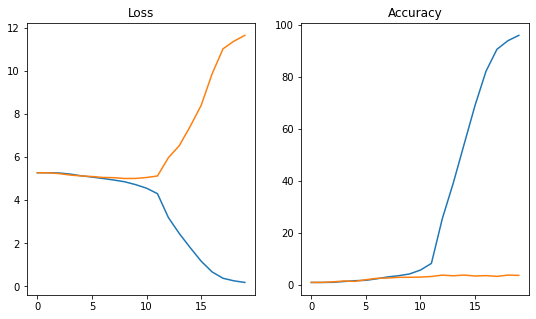

In [ ]:
f, ax = plt.subplots(1,2, figsize = (9, 5))
ax[0].set_title("Loss")
ax[0].plot(training_losses)
ax[0].plot(test_losses)
ax[1].set_title("Accuracy")
ax[1].plot(training_accs)
ax[1].plot(test_accs);

What has happened?

Я спробувала потренерувати 4 моделі, за основу архітектуи я взяла Alexnet. 
усі моделі оверфітнулись, з тією різницею, що простіші моделі показали кращий результат на тесті. Найкраща точність - 6%, у моделі з 2 згортковими слоями. 

### e.) Apply Dropouts

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 196) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.av_pool = nn.AdaptiveAvgPool2d((6, 6))
        self.drop = nn.Dropout() #dropout with default parametrs

        self.fc1 = nn.Linear(384 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.av_pool(self.pool(F.relu(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.drop(x) #apply dropout after the flatten layer
        x = F.relu(self.fc1(x))
        x = self.drop(x) #apply dropout after the first linner layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
    
        return x

net=Net()
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
training_losses, training_accs, test_losses, test_accs = train_model(net, criterion, optimizer, lrscheduler, n_epochs=20)

Epoch 1, duration: 81.00879621505737 s, loss: 5.280361387878656, acc: 0.634765625
test. loss: 5.275695358003889, acc: 0.8456659619450317
Epoch 2, duration: 80.8659598827362 s, loss: 5.277052849531174, acc: 0.830078125
test. loss: 5.2730955964043025, acc: 0.8456659619450317
Epoch 3, duration: 81.8839066028595 s, loss: 5.27430821955204, acc: 0.830078125
test. loss: 5.2685627521030485, acc: 0.8456659619450317
Epoch 4, duration: 84.01248621940613 s, loss: 5.267157878726721, acc: 0.830078125
test. loss: 5.253511239611913, acc: 0.9824648675537868
Epoch 5, duration: 84.43675780296326 s, loss: 5.215920962393284, acc: 1.0498046875
test. loss: 5.143356315673343, acc: 1.517224225842557
Epoch 6, duration: 82.87267684936523 s, loss: 5.125136476010084, acc: 1.42822265625
test. loss: 5.101572070802961, acc: 1.7659495087675663
Epoch 7, duration: 82.3738694190979 s, loss: 5.072018951177597, acc: 1.67236328125
test. loss: 5.0686016044919455, acc: 2.002238527546325
Epoch 8, duration: 81.93671011924744 s,

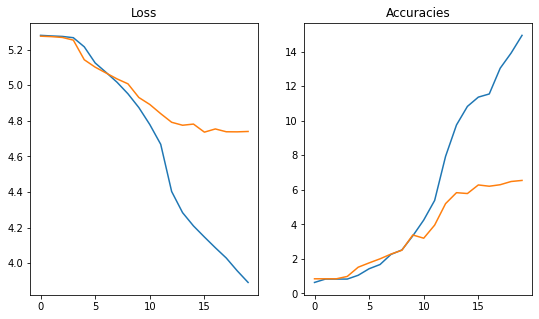

In [ ]:
f, ax = plt.subplots(1,2, figsize = (9, 5))
ax[0].set_title("Loss")
ax[0].plot(training_losses)
ax[0].plot(test_losses)
ax[1].set_title("Accuracies")
ax[1].plot(training_accs)
ax[1].plot(test_accs)

What has happened?


Моделі без DropOut швидко перенавчались. Що недивно, оскільки для кожного класу у нас розмір трейну всього лиш 100 екземплярів та у моделі досить значна кількість параметрів.

Тому модель з DropOut показала кращі результати, до того ж не перенавчилась за 20 епох. 
Що робить DropOut. За змовченням, параметр p = 0.5, це означає що рандомно 50% вхідного тензору прирівнюється до 0, тобто певні пікселі починають дорівнювати 0. 
Таким чином ці данні не тренуються, і, значить, не оверфітаються.
За рахунок рандому кожний раз беруться різні вхідні данні і результат усереднюється. 

DropOut мае відпрацьовувати лише під час трейну і це вже встроено в PyTorch.

### f.) Apply BatchNorm layers

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 196) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)

        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(192)
        self.batchnorm3 = nn.BatchNorm2d(384)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.av_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc1 = nn.Linear(384 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.batchnorm1(self.conv1(x)) #add mormalization to the first conv layer at first
        x = self.pool(F.relu(x))
        x = self.batchnorm2(self.conv2(x)) #add mormalization to the second conv layer 
        x = self.pool(F.relu(x))
        x = self.batchnorm3(self.conv3(x)) #add mormalization to last conv layer
        x = self.av_pool(self.pool(F.relu(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
    
        return x

net=Net()
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
training_losses, training_accs, test_losses, test_accs = train_model(net, criterion, optimizer, lrscheduler, n_epochs=20)

Epoch 1, duration: 86.470388174057 s, loss: 5.240759272128344, acc: 0.9521484375
test. loss: 5.125562938432845, acc: 2.0395473199850764
Epoch 2, duration: 86.13210678100586 s, loss: 5.0439846105873585, acc: 2.25830078125
test. loss: 5.028924194593278, acc: 2.213655018032583
Epoch 3, duration: 85.32903289794922 s, loss: 4.886931736022234, acc: 3.2958984375
test. loss: 4.917833559096805, acc: 3.121502300708867
Epoch 4, duration: 84.67061233520508 s, loss: 4.708194773644209, acc: 4.69970703125
test. loss: 4.852831287989541, acc: 3.7930605646063924
Epoch 5, duration: 85.84446716308594 s, loss: 4.496591843664646, acc: 6.7626953125
test. loss: 4.728041083093673, acc: 4.899888073622684
Epoch 6, duration: 84.46347618103027 s, loss: 4.217168943956494, acc: 9.48486328125
test. loss: 4.646266159557161, acc: 5.621191394105211
Epoch 7, duration: 84.69358921051025 s, loss: 3.93445180170238, acc: 12.451171875
test. loss: 4.583435111575657, acc: 7.7975376196990425
Epoch 8, duration: 84.44224858283997 

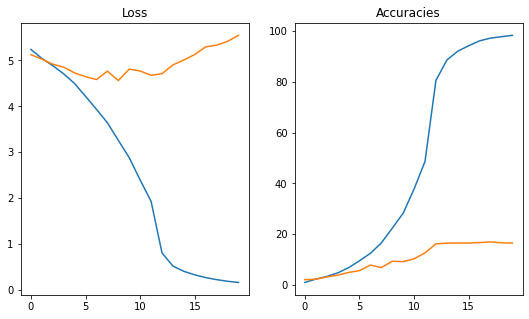

In [ ]:
f, ax = plt.subplots(1,2, figsize = (9, 5))
ax[0].set_title("Loss")
ax[0].plot(training_losses)
ax[0].plot(test_losses)
ax[1].set_title("Accuracies")
ax[1].plot(training_accs)
ax[1].plot(test_accs)

What has happened? 

Batch Normalization одразу показує кращі результати, ніж перші моделі. Оверфіт та всеж набагато швидше. Згідно з "Programming PyTorch for Deep Learning" Єна Поінтера, ця функція має заміняти повністю або частково DropOut, тож, я видалила останній з моделі.

Batch Normalization приводить наші данні у кожному батчі до нормального розподілу. Це важливо тому що, в іншому разу коєфіцієнти вносять не однаковий вклад у loss функцію. 
Нормалізація не тільки пришвидшую трейн, а й допомагає боротись зі зникаючими градієнтами.

Під час трейну оновлюються середне та стандартне відхилення для батчу і для усього датасету. І ці апроксимовані значення потім використовуються під час тесту(evaluation).

Я думаю, що кожного разу виникає оверфіт через не підходящу архітектуру CNN, завелика кількість параметрів моделі, величезні кернели для подібних зображень та малу вибірку.

### g.) What model configuration is optimal?

Так виникає питання, яка ж конфігурація моделі оптимальна. 
Для різних задач можуть бути кращими різні конфігурації. Загальне правильно, на мій погляд, зменшувати кількість вхідних параметрів, залишаючі найбільш значущі.

*   Перший параметр, який ми настраюємо це кількість вихідних параметрів. У моїх моделях він захардкодений, краще ініцюювати його при виклику функції, а далі розраховувати по формулі. Чим більше capacity моделі, тим на більших варіаціях вхідних данних модель може вчитися. Але великий ризик оверфіту. 
*   Pooling - друга, після вихідних параметрів, найсутевіша річ, на мій погляд, оскільки саме він дозволяє зменшити розмірність та зберегти лише найсуттевіші пікселі.
*   І нормалізація/dropout, які суттево покращують модель. Параметри нормалізації рахуються за формулою, а drop out можна підібрати тільки єкспериментальним шляхом, я б починала зі стандартного - 0.5
*   Кернели зазвичай мають стандартний розмір - 3х3, 7х7, 11х11. Чим більше кількість пікселів з картинки необхідна для розпізнавання - тим більший кернел.
*   Стандартне значення для падінгу - 1 або 2.
*   Страйд, мені здається, важливий параметр, який дозволяє зменшити розмірніть, та найкраще значення для нього можна підібрати, на мій погляд, лише екпериментальним шляхом. 

**Тож відповідь на питання: декілька convolution layers, Max Pooling, Batch Normalization/DropOut.**







### h.) What is the optimal layer sequence?

Для початку:
1.   Conv. Layer
2.   Batch.Norm
3.   Relu
4.   Повторити (...)
5.   Flatten Layer - понизити розмірніть
6.   Relu
7.   Linner Layer з вихідними параметрами та кількістю класів.


### i.) Apply image augmentation

In [ ]:
train_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_dir = "/content/drive/MyDrive/Colab Notebooks/cars/"

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 64, shuffle=False, num_workers = 2)

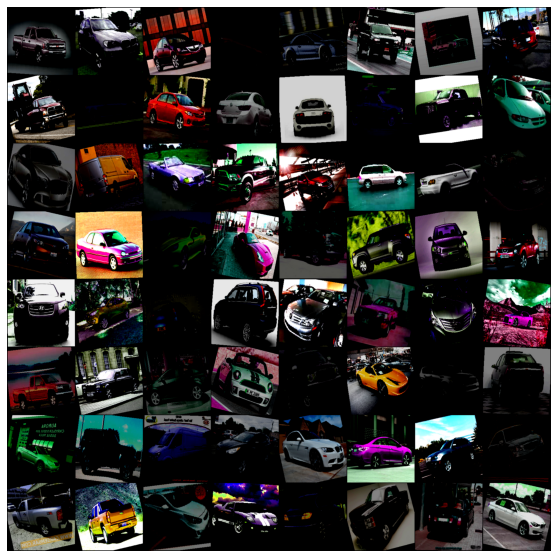

In [ ]:
inputs, classes = next(iter(trainloader))
out = torchvision.utils.make_grid(inputs)
imshow(out)

Used previous model

In [ ]:
training_losses, training_accs, test_losses, test_accs = train_model(net, criterion, optimizer, lrscheduler, n_epochs=30)

Epoch 1, duration: 137.64851117134094 s, loss: 5.279560409486294, acc: 0.74462890625
test. loss: 5.171846476812211, acc: 1.1565725656012933
Epoch 2, duration: 136.81266379356384 s, loss: 5.152828715741634, acc: 1.513671875
test. loss: 5.104484906272282, acc: 1.1565725656012933
Epoch 3, duration: 136.24427843093872 s, loss: 5.0651715695858, acc: 1.84326171875
test. loss: 5.012299747694106, acc: 1.915184678522572
Epoch 4, duration: 136.75947260856628 s, loss: 4.968744181096554, acc: 2.16064453125
test. loss: 5.0062094907912, acc: 2.2385275463250838
Epoch 5, duration: 135.81860899925232 s, loss: 4.842415031045675, acc: 3.173828125
test. loss: 4.828204576931302, acc: 3.1090660365626164
Epoch 6, duration: 136.74165058135986 s, loss: 4.69116147980094, acc: 4.45556640625
test. loss: 4.809228354030186, acc: 3.5816440741201343
Epoch 7, duration: 136.20151948928833 s, loss: 4.551490191370249, acc: 5.28564453125
test. loss: 4.64987852270641, acc: 4.775525432160179
Epoch 8, duration: 135.724758625

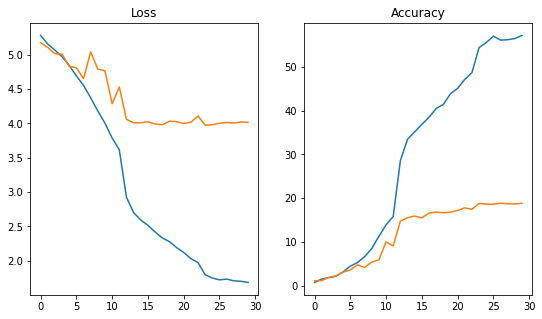

In [ ]:
f, ax = plt.subplots(1,2, figsize = (9, 5))
ax[0].set_title("Loss")
ax[0].plot(training_losses)
ax[0].plot(test_losses)
ax[1].set_title("Accuracy")
ax[1].plot(training_accs)
ax[1].plot(test_accs);

What has happened?

Модель показала кращі результати за рахунок того, що навчальна вибірка збільшилась.

Аугментація данних це один з дієвих способів боротьби з оверфітом, а також для навчання моделі, коли данних замало.
Суть аугментації доволі проста - шляхом перетворення існуючих данних доповнити датасет. Такими перетвореннями можуть бути: горизонтальне та вертикальне відображення, поворот на певний куб, обрізка, модифікація кольору. 
Важливо щоб перетворення були випадкові та реалістичні.
Наприклад, букет квітів можно відображати у будь-якому напрямку, а от котик догори дригом - це не реалістичне доповнення. 

### j.) Visualize filters and activation maps of a convolutional layer of your choice. 

In [ ]:
def filter_visual(w, name):
  fig=plt.figure(figsize=(12, 5))
  columns = 5
  for i in range(0, 5):
    fig.add_subplot(1, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
  print('{} convolutional layer'.format(name))
  plt.show()

First convolutional layer


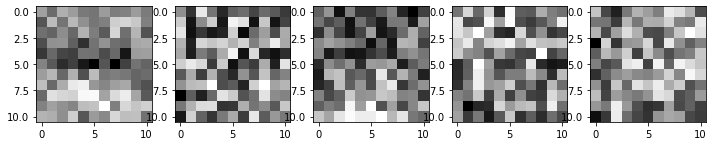

In [ ]:
weights = net.conv1.weight.data.cpu().numpy()
filter_visual(weights, 'First')

Second convolutional layer


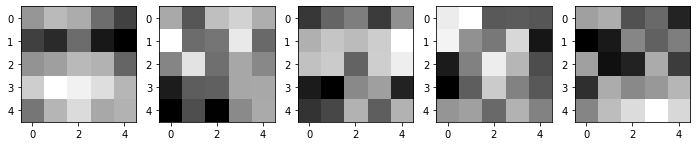

In [ ]:
weights = net.conv2.weight.data.cpu().numpy()
filter_visual(weights, 'Second')

Third convolutional layer


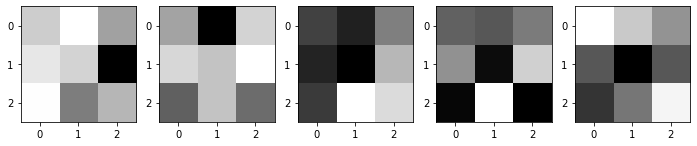

In [ ]:
weights = net.conv3.weight.data.cpu().numpy()
filter_visual(weights, 'Third')

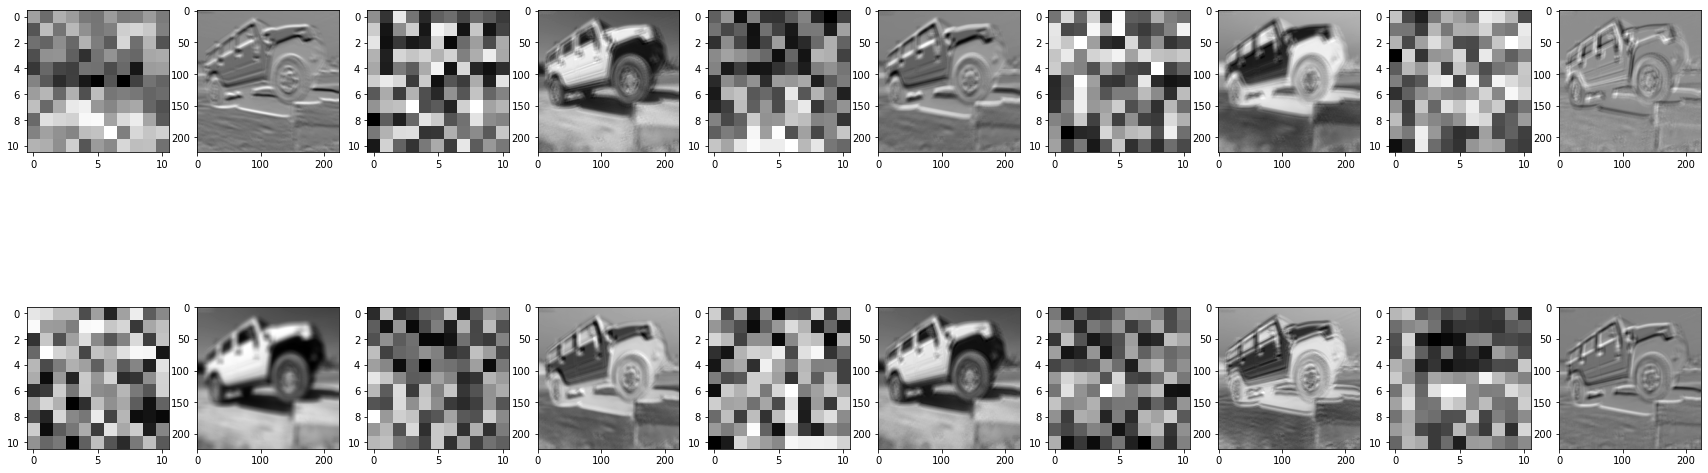

In [ ]:
# obtain one batch of testing images
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index and squeeze it as 3dim vector
idx = 3
img = np.squeeze(images[idx][0,:,:])

# Third conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    # filters
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    # images
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

What features each filter has learned to extract? Are they reasonable?


Більшість з фільтрів вище орієнтована на знаходження горизонтальних та вертикальних ліній, що має сенс, оскільки автомобілі дійсно можна розмежувати на основі силуету кузова. В той же час вони досить схожі між собою, гадаю даній моделі не вистачає ще одного сгорткового слою.

### k.) Load in the pre-trained base model

In [ ]:
train_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485,0.456, 0.406), (0.229, 0.224, 0.225))]) #normalize the data with model std and mean

test_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485,0.456, 0.406), (0.229, 0.224, 0.225))])

dataset_dir = "/content/drive/MyDrive/Colab Notebooks/cars/"

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 64, shuffle=False, num_workers = 2)

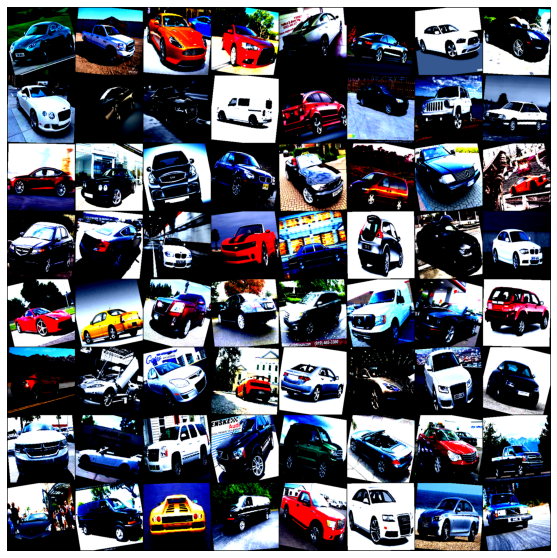

In [ ]:
inputs, classes = next(iter(trainloader))
out = torchvision.utils.make_grid(inputs)
imshow(out)

Pre-trained weights without the top layer. Freeze pre-trained model weights. Stack untrained classification layers (number of output neurons must be equal to the number of classes) on top of the pre-trained model.

In [ ]:
model_conv = models.resnet50(pretrained=True)
num_ftrs = model_conv.fc.in_features

#freeze
for param in model_conv.parameters():
  param.requires_grad = False

model_conv.fc = nn.Linear(num_ftrs, 196)
model_conv = model_conv.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
training_losses, training_accs, test_losses, test_accs = train_model(model_conv, criterion, optimizer, lrscheduler, n_epochs=20)

Epoch 1, duration: 116.59749293327332 s, loss: 4.370877726003528, acc: 13.916015625
test. loss: 4.13537859916687, acc: 16.627285163536875
Epoch 2, duration: 116.40875601768494 s, loss: 3.8505948465317488, acc: 21.35009765625
test. loss: 3.8855003014443414, acc: 18.318617087426937
Epoch 3, duration: 116.54809188842773 s, loss: 3.4733116570860147, acc: 28.11279296875
test. loss: 3.665194100803799, acc: 20.55714463375202
Epoch 4, duration: 115.66612648963928 s, loss: 3.2123045306652784, acc: 31.94580078125
test. loss: 3.470713816937946, acc: 23.852754632508393
Epoch 5, duration: 116.61600708961487 s, loss: 2.9888728950172663, acc: 36.70654296875
test. loss: 3.359326134598444, acc: 25.668449197860962
Epoch 6, duration: 117.61007809638977 s, loss: 2.8167118672281504, acc: 39.453125
test. loss: 3.218248606674255, acc: 27.123492102972268
Epoch 7, duration: 116.83958745002747 s, loss: 2.6653526592999697, acc: 42.07763671875
test. loss: 3.207290924730755, acc: 26.364879990050987
Epoch 8, durati

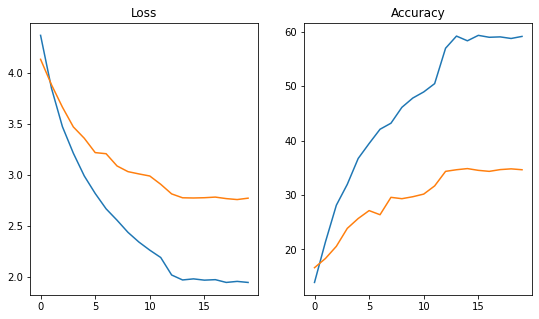

In [ ]:
f, ax = plt.subplots(1,2, figsize = (9, 5))
ax[0].set_title("Loss")
ax[0].plot(training_losses)
ax[0].plot(test_losses)
ax[1].set_title("Accuracy")
ax[1].plot(training_accs)
ax[1].plot(test_accs);

Which model performed better? Why?

Ваги цієї моделі заморожені - тобто згорткові слої не навчаються під час трейну. Що не завадило ResNet50 описати данні краще ніж моїй моделі, оскільки її архітектура набагато краща, та вона вже натренерована на данних.
ResNet містить Inception блок, який, як я зрозуміла, значно прискорює трейн, за рахунок зменшення розмірності і мінімальних втратах в данних.

### l.) Fine-tuning a pre-trained model

Unfreeze weights of a couple of the top layers of the pre-trained model. 

In [ ]:
model_conv = models.resnet50(pretrained=True)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 196)
model_conv = model_conv.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
training_losses, training_accs, test_losses, test_accs = train_model(model_conv, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 164.01917433738708 s, loss: 4.252238690853119, acc: 12.060546875
test. loss: 2.898519131872389, acc: 27.583633876383534
Epoch 2, duration: 164.44010996818542 s, loss: 1.9851324930787086, acc: 49.169921875
test. loss: 2.024313869930449, acc: 46.573809227708
Epoch 3, duration: 163.7829053401947 s, loss: 1.0667517725378275, acc: 70.78857421875
test. loss: 1.376914843916893, acc: 60.57704265638602
Epoch 4, duration: 164.38490271568298 s, loss: 0.6609525119420141, acc: 81.53076171875
test. loss: 1.0842090198208416, acc: 69.35704514363886
Epoch 5, duration: 164.8528025150299 s, loss: 0.41629241476766765, acc: 88.6474609375
test. loss: 0.8649734769548688, acc: 75.27670687725407
Epoch 6, duration: 165.28288888931274 s, loss: 0.3035064475843683, acc: 91.56494140625
test. loss: 0.8533471742319683, acc: 76.10993657505286
Epoch 7, duration: 164.72545075416565 s, loss: 0.19832729181507602, acc: 94.580078125
test. loss: 0.7006580114719414, acc: 79.55478174356423
Epoch 8, duration:

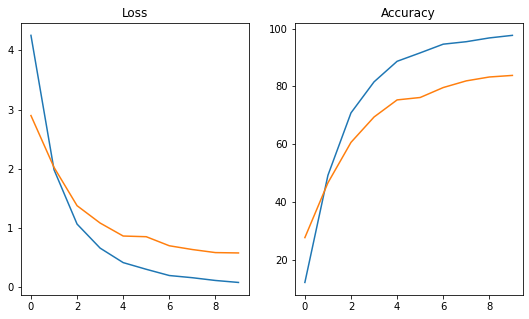

In [ ]:
f, ax = plt.subplots(1,2, figsize = (9, 5))
ax[0].set_title("Loss")
ax[0].plot(training_losses)
ax[0].plot(test_losses)
ax[1].set_title("Accuracy")
ax[1].plot(training_accs)
ax[1].plot(test_accs);

Which model performed better? Why?

Все ж таки модель без заморожених слоїв описує данні краще, ніж та сама з замороженими, за рахунок того, що їх ваги також підганяються під нашу вибірку.
Але модель тренирується у два рази довше.

### Conclusion

PyTorch виглядае складнішим за Tensorflow, та він здався мені більш flexible. Сподіваюсь я не зупинюсь і продовжу вивчати цей фреймворк.
Також у найближчому майбутньому я хочу спробувати претреновані моделі на змаганнях.